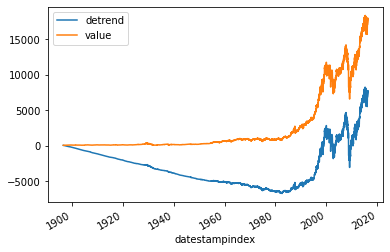

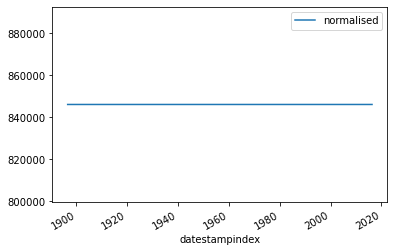

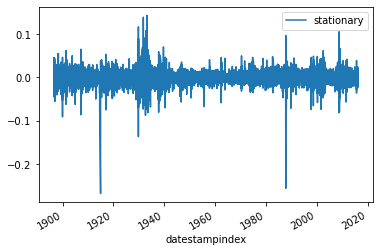

['date', 'close', 'datestamp', 'value', 'returns', 'percentchange', 'abspercentchange', 'detrend', 'normalised', 'stationary', 'year', 'month', 'doy', 'dom', 'week', 'dow', 'dayname', 'hour']
32601


,date,close,datestamp,value,returns,percentchange,abspercentchange,detrend,normalised,stationary,year,month,doy,dom,week,dow,dayname,hour
datestampindex,,,,,,,,,,,,,,,,,,
1896-07-14,1896-07-14,33.43,1896-07-14,33.43,NaN,NaN,NaN,33.430000,845986.512558,NaN,1896,7,196,14,29,1,Tuesday,0
1896-07-15,1896-07-15,32.28,1896-07-15,32.28,-1.15,-0.034400,0.034400,31.967439,845986.512558,-0.035006,1896,7,197,15,29,2,Wednesday,0
1896-07-16,1896-07-16,31.95,1896-07-16,31.95,-0.33,-0.010223,0.010223,31.324877,845986.512558,-0.010276,1896,7,198,16,29,3,Thursday,0
1896-07-17,1896-07-17,31.94,1896-07-17,31.94,-0.01,-0.000313,0.000313,31.002316,845986.512558,-0.000313,1896,7,199,17,29,4,Friday,0
1896-07-18,1896-07-18,31.50,1896-07-18,31.50,-0.44,-0.013776,0.013776,30.249755,845986.512558,-0.013872,1896,7,200,18,29,5,Saturday,0


In [7]:
# trying to consolidate colab FFT_Norm notebook locally
# !pip install scaleogram
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from preprocess import normalise_data, detrend, preprocess_frame
from matplotlib import pyplot as plt
from preprocess import load_frame

# df = pd.read_csv("DATASET.CSV")
# df = preprocess_frame(df)
df = load_frame()

df[["detrend", "value"]].plot()
df[["normalised"]].plot()
df[["stationary"]].plot()
plt.show()

print ( list(df.columns) )
print (len(df) )
df.head()



In [ ]:
from scipy import signal
import plotly.express as px
import plotly.graph_objects as go

# https://dsp.stackexchange.com/questions/2426/terminology-spectrum-spectrogram-spectrograph-sonogram-etc
# https://scipy-lectures.org/intro/scipy/auto_examples/plot_spectrogram.html
def scipy_spectrogram(df, chart_column="close"):
    sig = df[chart_column]
    freqs, times, spectrogram = signal.spectrogram(sig)
    
    from matplotlib import pyplot as plt
    plt.figure(figsize=(5, 4))
    plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
    plt.title('Spectrogram')
    plt.ylabel('Frequency band')
    plt.xlabel('Time window')
    plt.tight_layout()
    
    '''
    print(spectrogram.shape)
    fig = px.imshow(spectrogram)
    fig.show()
    '''

def scipy_psd(df, chart_column="close"):
    sig = df[chart_column]
    freqs, psd = signal.welch(sig)

    from matplotlib import pyplot as plt
    plt.figure(figsize=(5, 4))
    plt.semilogx(freqs, psd)
    plt.title('PSD: power spectral density')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.tight_layout()

    # wavelength = len(df) / (freqs + 1)
    wavelength = freqs * len(df)    # ?
    # fig = px.line(x=freqs, y=psd, log_y=True)
    # fig = px.line(freq_df, x="frequency", y="amplitude", hover_data=["frequency", "wavelength"], log_y=True)
    fig = go.Figure()
    fig.add_scatter(x=freqs, y=psd, hovertext=wavelength, mode="lines")
    # fig.add_scatter(x=freqs, y=psd, mode="lines")
    fig.update_layout(yaxis_type="log")
    fig.show()
    
# scipy_spectrogram(df)
scipy_psd(df, "value")

In [ ]:
# debugging indexSelector, works well with DateScale only?
from bqplot import pyplot as plt, Figure, Axis
import bqplot as bq
from bqplot.interacts import IndexSelector, FastIntervalSelector
from bqplot.interacts import BrushIntervalSelector
from ipywidgets import ToggleButtons, VBox, HTML
import ipywidgets as widgets

# compare: https://kite.com/python/answers/how-to-plot-a-power-spectrum-in-python
def get_psd(df, chart_column="close"):
    # sampling_rate = 24  # 24 hours in a day
    sampling_rate = 365

    # psd method
    # https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python
    # freq_domain = np.fft.fft(df[chart_column])
    freq_domain = np.fft.rfft(df[chart_column])
    amp = np.abs(freq_domain)
    # frequency = np.fft.fftfreq(len(amp))
    # idx = np.argsort(frequency)
    power_spectrum = np.square(amp)
    frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))

    wavelength = len(df) / (frequency + 1)
    # freq_df = pd.DataFrame({"amplitude": ps[idx], "frequency": frequency[idx], "wavelength": wavelength})
    freq_df = pd.DataFrame({"amplitude": power_spectrum, "frequency": frequency, "wavelength": wavelength})
    # plt.plot(freqs[idx], ps[idx])
    return freq_df
    
def get_fft_spectrum(df, chart_column="close"):
    freq_domain = np.fft.fft(df[chart_column])
    amp = np.abs(freq_domain)
    amp = amp[:int(len(amp)/2)]
    frequency = np.array(range(len(amp)))
    
    wavelength = len(df) / (frequency + 1)
    freq_df = pd.DataFrame({"amplitude": amp, "frequency": frequency, "wavelength": wavelength})
    return freq_df

def selector_plot(freq_df, x_col, y_col, selector_cls):
    
    def index_change_callback(change):
        db_index.value = 'The selected date is ' + str(change.new)
    
    # x_sc = bq.LogScale()
    # x_sc = bq.LinearScale()
    x_sc = bq.DateScale()
    y_sc = bq.LogScale()

    x_ax = Axis(label=x_col, scale=x_sc)
    x_ay = Axis(label=(y_col), scale=y_sc, orientation='vertical')
    lc = bq.Lines(x=freq_df[x_col], y=freq_df[y_col], scales={'x': x_sc, 'y': y_sc})
    
    selector = IndexSelector(scale=x_sc, marks=[lc])    
    selector.observe(index_change_callback, names=['selected'])
    fig_bq = Figure(marks=[lc], axes=[x_ax, x_ay], interaction=selector)
    return fig_bq

db_index = HTML(value='[]')
# freq_df = get_fft_spectrum(df)
freq_df = get_psd(df)

fig_bq_f = selector_plot(freq_df, "frequency", "amplitude", IndexSelector)

VBox([db_index, fig_bq_f])

In [2]:
# from npfft_filters.py
# TODO add detrend and forward projected values
range_start = range_end = 0

from bqplot import pyplot as plt, Figure, Axis
import bqplot as bq
from bqplot.interacts import IndexSelector, FastIntervalSelector
from bqplot.interacts import BrushIntervalSelector
from ipywidgets import ToggleButtons, VBox, HTML
import ipywidgets as widgets

x_sc = bq.LinearScale()
# x_sc = bq.DateScale()
# x_sc = bq.LogScale()
y_sc = bq.LogScale()

def index_change_callback(change):
    global range_start, range_end, band_ranges
    # print (change.new)
    # IndexSelector
    if len(change.new) == 1:
        range_start = change.new[0]
        
    # BrushIntervalSelector
    if len(change.new) == 2:
        range_start = change.new[0]
        range_end = change.new[-1]
    
    fr = freq_domain[int(range_start)]
    # freq here is radians? should i use fftfreq?
    # https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python
    # https://stackoverflow.com/questions/59979354/what-is-the-difference-between-numpy-fft-fft-and-numpy-fft-fftfreq
    # https://stackoverflow.com/questions/25624548/fft-real-imaginary-abs-parts-interpretation
    wavelength = len(df) / (range_start + 1)
    f_data = (fr, wavelength)
    # fr.real, fr.imag
    
    db_index.value = 'The selected date is ' + str(change.new) + ' ' + str(band_ranges) + ' ' + str(f_data)

def selector_plot(freq_df, x_col, y_col, selector_cls):
    x_ax = Axis(label=x_col, scale=x_sc)
    x_ay = Axis(label=(y_col), scale=y_sc, orientation='vertical')
    def_tt = bq.Tooltip(fields=['frequency', 'amplitude'])
    lc = bq.Lines(x=freq_df[x_col], y=freq_df[y_col], scales={'x': x_sc, 'y': y_sc}, tooltip=def_tt)
    # line = plt.plot(freq_df.index, freq_df.amplitude, 'b')
    # lc.on_element_click(lambda self, x: print(x))
    # lc.on_hover(lambda x: print(x))
    
    # selector_index = IndexSelector(scale=x_sc, marks=[lc])
    # selector_fast = FastIntervalSelector(scale=x_sc, marks=[lc])
    # selector_brush_interval = BrushIntervalSelector(scale=x_sc, marks=[lc])
    
    selector = selector_cls(scale=x_sc, marks=[lc])
    selector.observe(index_change_callback, names=['selected'])
    # fig_bq = Figure(marks=[lc], axes=[x_ax, x_ay], interaction=selector)
    fig_bq = Figure(marks=[lc], axes=[x_ax, x_ay])
    fig_bq.interaction = selector
    # plt.show()
    return fig_bq
    
def plot_np_fft_spectrum(df, chart_column="close"):
    freq_domain = np.fft.fft(df[chart_column])
    amp = np.abs(freq_domain)
    amp = amp[:int(len(amp)/2)]
    frequency = np.array(range(len(amp)))
    print (len(df))
    print (len(amp))
    # wavelength = len(df) / (frequency + 1)
    wavelength = len(df) / frequency
    freq_df = pd.DataFrame({"amplitude": amp, "frequency": frequency, "wavelength": wavelength})
    
    fig = px.line(freq_df, x="frequency", y="amplitude", hover_data=["frequency", "wavelength"], log_y=True)
    # fig = px.line(freq_df, x="wavelength", y="amplitude", hover_data=["frequency", "wavelength"], log_y=True)
    # fig.update_layout(yaxis_type="log")
    # fig.show()

    import plotly.graph_objects as go
    fw_plotly = go.FigureWidget(fig)
    def test(trace, points, state):
        print(points)
    fw_plotly.data[0].on_click(test)
    
    fig_bq = selector_plot(freq_df, "frequency", "amplitude", IndexSelector)
    # fig_bq = selector_plot(freq_df, "frequency", "amplitude", BrushIntervalSelector)
    # fig_bq = selector_plot(freq_df, "wavelength", "amplitude")
    
    return freq_domain, fig_bq, fw_plotly

db_index = HTML(value='[]')
# freq_domain, fig_bq, fw_plotly = plot_np_fft_spectrum(df, "stationary")
freq_domain, fig_bq, fw_plotly = plot_np_fft_spectrum(df, "close")
toolbar = bq.Toolbar(figure=fig_bq)


band_ranges = []
def add_range(event):
    global range_start, range_end, band_ranges
    band_ranges.append([range_start, range_end])
    print ((band_ranges, event))
def clear_range(event):
    global range_start, range_end, band_ranges
    band_ranges = []
    print ((band_ranges, event))
    
range_btn = widgets.Button(description='Add Range', icon='check')
range_btn.on_click(add_range)
clear_range_btn = widgets.Button(description='Clear Range', icon='check')
clear_range_btn.on_click(clear_range)

VBox([db_index, fig_bq, fw_plotly, toolbar, range_btn, clear_range_btn])


1996
998


In [4]:
# npfft_filters.py
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
n = len(freq_domain)

# fig = px.line(x=range(n), y=df.Close)
# fig.show()
fig.add_scatter(x=df.index, y=df.close, mode="lines", row=1, col=1, name="close")

# TODO add remove bandpass list / i_freq list in bqplot
# create a bandpass
low = 29
high = 51
# important_freq = np.zeros(n, dtype=complex)
# important_freq[low:high] = freq_domain[low:high]
# print (sum(important_freq))

# 126hz, 15 days, 238%
# 132 Hz, 14.4 days, 114%
# 91 Hz, 21 days, 272%
# 50 Hz, 37 days, 207%
# 15 Hz, 116 days, 156%
# buy hold 450%

# bandpass
'''
important_freq = freq_domain.copy()
important_freq[:low:-1] = 0
important_freq[high:] = 0
# print (important_freq)
smoothed_values = np.real(np.fft.ifft(important_freq))
fig.add_scatter(x=df.index, y=smoothed_values, mode="lines", row=1, col=1, name="Sine_MA")
'''

# combine individual freq
'''
important_freq = np.zeros(n, dtype=complex)
for index, i_freq in enumerate([int(x[0]) for x in band_ranges]):
    print (i_freq)
    important_freq[i_freq] = freq_domain[i_freq]
smoothed_values = np.real(np.fft.ifft(important_freq))
fig.add_scatter(x=df.index, y=smoothed_values, mode="lines", row=1, col=1, name=f"freqMA")
'''

# pick individual freq
# for index, i_freq in enumerate([38]):
for index, i_freq in enumerate([int(x[0]) for x in band_ranges]):
    print (i_freq)
    important_freq = np.zeros(n, dtype=complex)
    # important_freq[i_freq] = np.real(freq_domain[i_freq])
    important_freq[i_freq] = freq_domain[i_freq]
    smoothed_values = np.real(np.fft.ifft(important_freq))
    # print (freq_domain[i_freq])
    # fig = px.line(x=df.index, y=smoothed_values)
    # fig.show()
    fig.add_scatter(x=df.index, y=smoothed_values, mode="lines", row=2, col=1, name=f"freq{i_freq}")
    
    print (min(smoothed_values), max(smoothed_values))
    df['BUY'] = False
    df['SELL'] = False
    # print (smoothed_values == min(smoothed_values))
    SMOOTH_MIN = min(smoothed_values)
    SMOOTH_MAX = max(smoothed_values)
    THRESHOLD = 0.01 * SMOOTH_MAX
    BUY_MASK = abs(smoothed_values - SMOOTH_MIN) < THRESHOLD
    SELL_MASK = abs(smoothed_values - SMOOTH_MAX) < THRESHOLD
    sine_series = pd.Series(smoothed_values)
    BUY_MASK = (sine_series < sine_series.shift(1)) & (sine_series < sine_series.shift(-1))
    SELL_MASK = (sine_series > sine_series.shift(1)) & (sine_series > sine_series.shift(-1))
    df.loc[BUY_MASK.values, 'BUY'] = True
    df.loc[SELL_MASK.values, 'SELL'] = True
    # plot buy sell on sine wave
    if "BUY" in list(df.columns):
        buys = df[df.BUY]
        fig.add_scatter(x=buys.index, y=buys.close, mode="markers", marker=dict(size=10, symbol=5, color="green"), name="Buys")    
    if "SELL" in list(df.columns):
        sells = df[df.SELL]
        fig.add_scatter(x=sells.index, y=sells.close, mode="markers", marker=dict(size=10, symbol=6, color="red"), name="Sells")

from backtesting import plot_backtest
df['Date'] = df.index
fig_a, fig_b = plot_backtest(df)
fig_a.show()
fig_b.show()

# compare buy and hold
'''
df['BUY'] = df['SELL'] = False
df.loc["2014-11-28", 'BUY'] = True
fig_a, fig_b = plot_backtest(df)
fig_a.show()
fig_b.show()
'''

fig.update_layout(yaxis_type="log")
fig

366
-15.911909561406743 15.911909561406741


In [ ]:
print (band_ranges)
plot_fft_spectrum(df, "normalised")
# plot_wavelet(df, "close")

In [ ]:
def plot_fft_spectrum(df, chart_column="close"):
    df = df.dropna()
    data = df[chart_column]

    #normalize, do we need to normalize?
    data = (data - np.mean(data)) / np.std(data)
    time = range(len(data))

    fftdata = np.fft.fft(data)
    fftdatafreq = np.zeros((len(data)))
    for i in range(len(fftdata)):
     fftdatafreq[i] = abs(fftdata[i].real)
    # only plot half of the symetrical plot
    first_half = fftdatafreq[:len(fftdatafreq) // 2]
    '''
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency")
    plt.plot(time, fftdatafreq)
    plt.plot(time[:len(fftdatafreq) // 2], fftdatafreq[:len(fftdatafreq) // 2])
    plt.show()
    '''
    px.line(x=time[:len(fftdatafreq) // 2], y=fftdatafreq[:len(fftdatafreq) // 2]).show()
    maxfreq = np.argmax(fftdatafreq)

In [ ]:
# https://www.coursera.org/lecture/advanced-machine-learning-signal-processing/scaleograms-YYU4A

def plot_wavelet(df, chart_column="close"):
    # currently (03/2019) scaleogram needs install via https://github.com/alsauve/scaleogram
    # because an old PyWavelets (0.5.2) is installend and PyWavelets > 1.0 is needed
    import scaleogram as scg
    import pywt

    # choose default wavelet function for the entire notebook
    # scg.set_default_wavelet('cmor1-1.5')

    # scg.wfun.get_wavlist(), list of types
    # Try these ones to see various compromises between scales and time resolution
    #scg.set_default_wavelet('cgau5')
    #scg.set_default_wavelet('cgau1')
    #scg.set_default_wavelet('shan0.5-2')
    #scg.set_default_wavelet('mexh')

    # fig, (ax1, ax2) = plt.subplots(2)
    # ax1, ax2 = df[["Close", "Volume"]].plot(subplots=True, sharex=True, logy=True)
    # ax1, ax2 = df[["Close", "Volume"]].plot(subplots=True)

    # plt.ion()
    data = df[chart_column].values
    # df[["Close"]].plot(logy=True, axes=ax1)
    # df[["Close"]].plot(logy=True)
    ax = scg.cws(data, xlabel="Date", ylabel="Price", yscale="log")
    # ax = scg.cws(data, xlabel="Date", ylabel="Price")
    # ax = scg.cws(data, xlabel="Date", ylabel="Price", yscale="log", ax=ax2)
    # date_labels = df.index.year.astype(str) + df.index.month_name() # +df.index.day.astype(str)
    # date_labels = df.index.date
    # date_labels = df.index.year
    # ax.set_xticklabels(date_labels)
    # ax.set_xticklabels([1,2,3,4,5,6,7,8,9])
    # print((len(data), len(date_labels)))
    plt.show()

# !pip install scaleogram
px.line(x=df.index, y=df.stationary).show()
plot_wavelet(df, "stationary")

3.333333333333334
       Time  Amplitude
4995  49.95  -0.094108
4996  49.96  -0.075327
4997  49.97  -0.056519
4998  49.98  -0.037690
4999  49.99  -0.018848


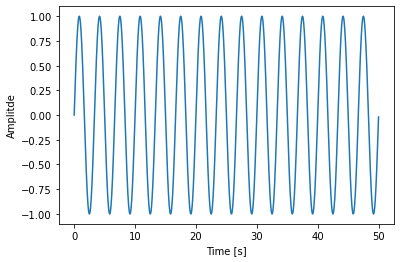

In [109]:
# sinewave.py
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi, sin, linspace
# t = np.linspace(0, 0.15, 500)
t = np.linspace(0, 1000, 1000)
# s = np.sin(40 * 2 * np.pi * t) + 0.5 * np.sin(90 * 2 * np.pi * t)

def plot_fft_spectrum(data):
	time = range(len(data))
	fftdata = np.fft.fft(data)
	fftdatafreq = np.zeros((len(data)))
	for i in range(len(fftdata)):
	 fftdatafreq[i] = abs(fftdata[i].real)
	plt.ylabel("Amplitude")
	plt.xlabel("Frequency")
	plt.plot(time, fftdatafreq)
	plt.show()


def daily_sinewave():
	sample_rate = 365 # 365 days per year
	sample_length = 1996 / 365. # 1996 days since 2010, about 5 years
	time = np.arange(0, sample_length, 1 / sample_rate)
	
	all_s = []
	for frequency in [4.0]:
		# frequency = 0.3	# number of cycles per second (hertz)
		wavelength = sample_length / frequency * 2 / sample_rate
		print (f"{wavelength}")
		amplitude = np.sin(2*pi*frequency*time)
		all_s.append(amplitude)
	data = sum(all_s)

	sine_df = pd.DataFrame({"Time": time, "Amplitude": data})
	print(sine_df.tail())
	return sine_df

def simple_sinewave():
	sample_rate = 100 # samples per second
	sample_length = 50 # total seconds
	time = np.arange(0, sample_length, 1 / sample_rate)
	
	all_s = []
	for frequency in [0.3]:
		# frequency = 0.3	# number of cycles per second (hertz)
		wavelength = sample_length / frequency * 2 / sample_rate
		print (f"{wavelength}")
		amplitude = np.sin(2*pi*frequency*time)
		all_s.append(amplitude)
	data = sum(all_s)

	sine_df = pd.DataFrame({"Time": time, "Amplitude": data})
	print(sine_df.tail())
	return sine_df


if __name__ == "__main__":
	df = simple_sinewave()
	plt.ion()
	plt.ylabel("Amplitde")
	plt.xlabel("Time [s]")
	# plt.plot(t, df["Amplitude"])
	plt.plot(df["Time"], df["Amplitude"])
	px.line(df, x="Time", y="Amplitude").show()
	df["close"] = df["value"] = df["Amplitude"]
	plt.show()
	# plot_fft_spectrum(df)
